In [ ]:
# !pip install mediapipe

In [ ]:
import os
import csv
import cv2
import math
import numpy as np
import pandas as pd
import mediapipe as mp
import matplotlib.pyplot as plt

from google.colab import drive
from google.colab.patches import cv2_imshow
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten

In [ ]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Path to CSV file
csv_file = "/content/drive/MyDrive/all_landmarks.csv"

Mounted at /content/drive


In [ ]:
# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file)

# Display the DataFrame
df.head()

,Image,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,...,X464,Y464,X465,Y465,X466,Y466,X467,Y467,X468,Y468
0,/content/drive/MyDrive/Dataset Asli/Circle/165...,144.0,216.0,144.0,186.0,144.0,194.0,138.0,155.0,144.0,...,168.0,130.0,163.0,133.0,161.0,134.0,208.0,127.0,212.0,124.0
1,/content/drive/MyDrive/Dataset Asli/Circle/165...,152.0,193.0,150.0,167.0,151.0,176.0,142.0,143.0,149.0,...,168.0,127.0,164.0,129.0,161.0,130.0,203.0,125.0,208.0,122.0
2,/content/drive/MyDrive/Dataset Asli/Circle/165...,150.0,200.0,150.0,171.0,151.0,180.0,144.0,140.0,151.0,...,179.0,119.0,173.0,121.0,170.0,122.0,223.0,117.0,228.0,115.0
3,/content/drive/MyDrive/Dataset Asli/Circle/165...,153.0,204.0,152.0,180.0,152.0,188.0,146.0,153.0,152.0,...,171.0,131.0,167.0,132.0,165.0,134.0,208.0,126.0,211.0,123.0
4,/content/drive/MyDrive/Dataset Asli/Circle/165...,154.0,204.0,153.0,178.0,153.0,186.0,144.0,150.0,152.0,...,169.0,129.0,165.0,131.0,162.0,133.0,205.0,124.0,209.0,122.0


In [ ]:
# Load FaceMesh model
mp_face_mesh = mp.solutions.face_mesh

# Load image paths and landmark data from CSV
image_paths = []
landmark_data = []

# Load image paths and landmark data from CSV
with open(csv_file, "r") as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip header row
    count = 0  # Counter to track the number of rows
    for row in csv_reader:
        image_paths.append(row[0])
        landmarks = [float(x) for x in row[1:]]
        landmark_data.append(landmarks)
        count += 1
        if count == 550:  # Stop after reading 5 rows
            break

image_paths = np.array(image_paths)
landmark_data = np.array(landmark_data)

# Prepare the training data
X_train = []
y_train = []

for image_path in image_paths:
    # Load image
    image = cv2.imread(image_path)

    # Convert image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Process image
    results = mp_face_mesh.FaceMesh().process(image)

    # Get face landmarks
    if results.multi_face_landmarks:
        landmarks = results.multi_face_landmarks[0]
    else:
        landmarks = None

    # Extract landmark coordinates
    if landmarks:
        landmark_coordinates = []
        for landmark in landmarks.landmark:
            x = int(landmark.x * image.shape[1])
            y = int(landmark.y * image.shape[0])
            landmark_coordinates.extend([x, y])

        X_train.append(landmark_coordinates)
        y_train.append(landmark_data[np.where(image_paths == image_path)][0])

    # Clear variables to release memory
    del image, results, landmarks, landmark_coordinates

X_train = np.array(X_train)
y_train = np.array(y_train)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the model architecture
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(936,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(936))  # Output layer with 468 nodes (2 coordinates per landmark)
model.compile(loss='mean_squared_error', optimizer=Adam())

# Define the ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint("Arvigo_Landmark.h5", monitor='val_loss', save_best_only=True, mode='min')

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=2500, validation_data=(X_val, y_val), callbacks=[checkpoint])

Streaming output truncated to the last 5000 lines.
14/14 [==============================] - 2s 42ms/step - loss: 10329.3721 - val_loss: 863.2422
Epoch 2/2500
14/14 [==============================] - 0s 21ms/step - loss: 587.5053 - val_loss: 224.6308
Epoch 3/2500
14/14 [==============================] - 2s 126ms/step - loss: 136.5328 - val_loss: 92.9465
Epoch 4/2500
14/14 [==============================] - 0s 22ms/step - loss: 69.1779 - val_loss: 58.3421
Epoch 5/2500
14/14 [==============================] - 0s 21ms/step - loss: 50.3058 - val_loss: 51.6294
Epoch 6/2500
14/14 [==============================] - 2s 160ms/step - loss: 46.2585 - val_loss: 49.3111
Epoch 7/2500
14/14 [==============================] - 0s 29ms/step - loss: 45.3913 - val_loss: 49.6019
Epoch 8/2500
14/14 [==============================] - 0s 28ms/step - loss: 57.9380 - val_loss: 65.8282
Epoch 9/2500
14/14 [==============================] - 0s 28ms/step - loss: 50.7971 - val_loss: 50.6084
Epoch 10/2500
14/14 [=====

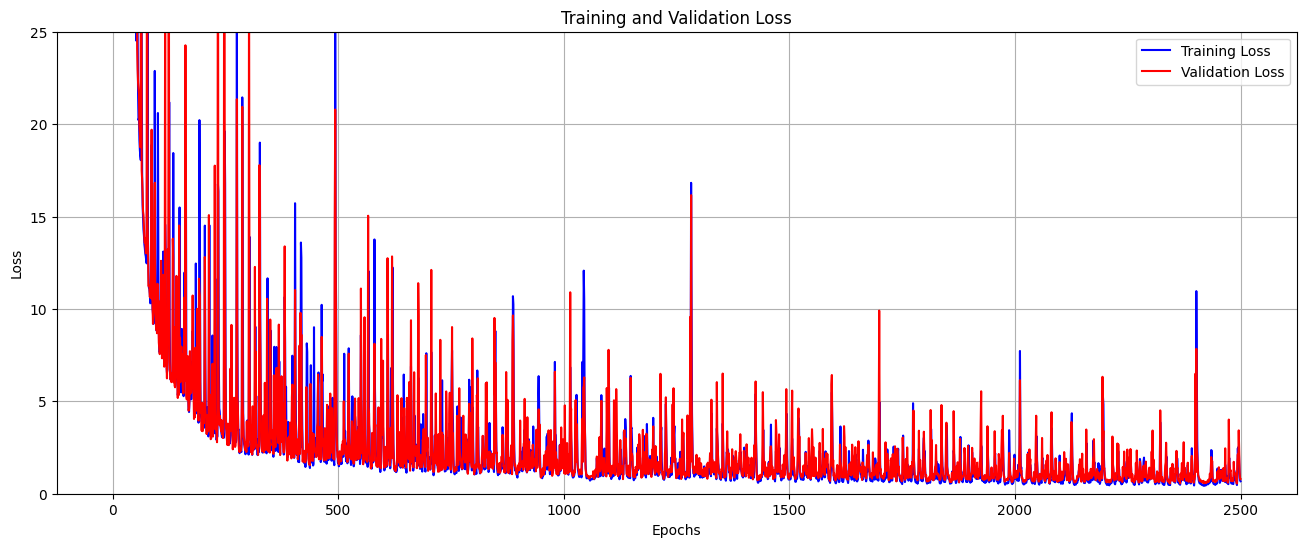

In [ ]:
# Get training and validation loss from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 25)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the validation set
val_loss = model.evaluate(X_val, y_val)

# Print the validation loss
print('Validation Loss:', val_loss)

4/4 [==============================] - 0s 6ms/step - loss: 0.7929
Validation Loss: 0.7929425239562988


1/1 [==============================] - 0s 161ms/step


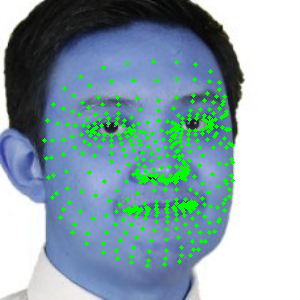

In [ ]:
# Load the best model from the checkpoint
best_model = load_model("Arvigo_Landmark.h5")

# Load a new test image
test_image = cv2.imread("4.jpg")
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

# Process the test image
test_results = mp_face_mesh.FaceMesh().process(test_image)

# Get face landmarks from the test image
if test_results.multi_face_landmarks:
    test_landmarks = test_results.multi_face_landmarks[0]
else:
    test_landmarks = None

# Extract landmark coordinates from the test image
if test_landmarks:
    test_landmark_coordinates = []
    for landmark in test_landmarks.landmark:
        x = int(landmark.x * test_image.shape[1])
        y = int(landmark.y * test_image.shape[0])
        test_landmark_coordinates.append((x, y))

    # Reshape the input for the model prediction
    test_input = np.array(test_landmark_coordinates).reshape(1, -1)

    # Predict the landmarks on the test image using the best model
    predicted_landmarks = best_model.predict(test_input)

    # Draw the predicted landmarks on the test image
    for landmark in predicted_landmarks.reshape(-1, 2):
        x = int(landmark[0])
        y = int(landmark[1])
        cv2.circle(test_image, (x, y), 2, (0, 255, 0), -1)

    # Display the test image with predicted landmarks
    cv2_imshow(test_image)
else:
    print("No face landmarks detected in the test image.")